<a href="https://colab.research.google.com/github/torayeff/RoboCupHumanoid/blob/master/Sweaty1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RoboCupHumanoid Setup for Google Colab

In [ ]:
# cleaning
!rm -rf data/
!rm -rf sweaty_1\ \(for\ comparing\)
!rm -rf *.csv *.py *.md *.jpg

### Install Pytorch

In [ ]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q torch==1.0.0 torchvision

### Clone RoboCupHumanoid

In [3]:
!git clone https://github.com/torayeff/RoboCupHumanoid.git
!mv RoboCupHumanoid/* .
!rm RoboCupHumanoid/ -rf
!mkdir data

Cloning into 'RoboCupHumanoid'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 105 (delta 44), reused 57 (delta 14), pack-reused 0
Receiving objects: 100% (105/105), 1.07 MiB | 10.42 MiB/s, done.
Resolving deltas: 100% (44/44), done.


### Copy data folder from Google Drive to the current runtime

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp drive/'My Drive'/labivision/data/train.zip data/
!unzip -q data/train.zip -d data/
!rm data/train.zip

### Training

In [1]:
import torch
import torch.nn as nn
import utils as utils
from SweatyNet1 import SweatyNet1
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak
import matplotlib.cm as cm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
modelPath = 'pretrained_models/epoch_100.model'

model = SweatyNet1()
model.to(device)

if modelPath != '':
    print("Loading Sweaty")
    model.load_state_dict(torch.load(modelPath, map_location='cpu'))


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

trainset = utils.SoccerBallDataset("data/train/data.csv", "data/train", downsample=4)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

Loading Sweaty
Computing teacher signals...
Elapsed: 4.317560 sec.


#### Before Training

[['407', '216', '458', '268']]


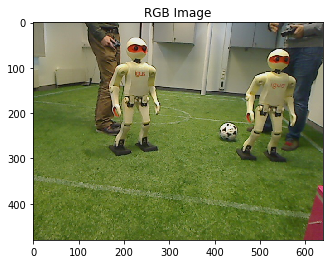

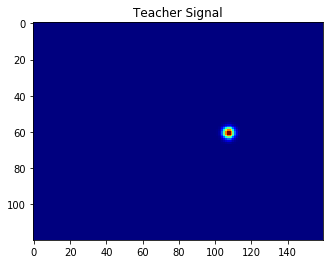

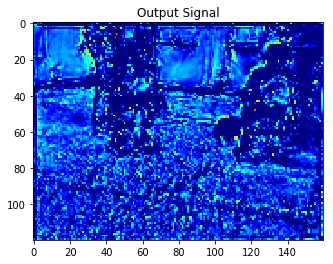

In [9]:
idx = 1

image = trainset[idx]['image']
signal = np.array(trainset[idx]['signal'].squeeze())
print(trainset[idx]['bndboxes'])
output = model(image.unsqueeze(0).float().to(device))
output_signal = np.array(output.cpu().squeeze().detach())

plt.title("RGB Image")
plt.imshow(np.array(image).transpose(1, 2, 0))
plt.show()

plt.title("Teacher Signal")
plt.imshow(signal, cmap=cm.jet)
plt.show()


plt.title("Output Signal")
plt.imshow(output_signal, cmap=cm.jet)
plt.show()

In [5]:
epochs = 100

for epoch in range(epochs):
    epoch_loss = 0
    tic = time.time()
    for i, data in enumerate(trainloader):
        optimizer.zero_grad()

        images = data['image'].float().to(device)
        signals = data['signal'].float().to(device)

        outputs = model(images)

        loss = criterion(signals, outputs)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    epoch_loss /= len(trainset)
    epoch_time = time.time() - tic
    print("Epoch: {}, loss: {}, time: {:.5f} seconds".format(epoch + 1, epoch_loss, epoch_time))


Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", 

KeyboardInterrupt: 

#### After training

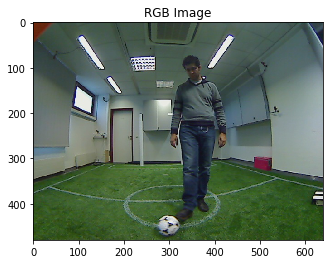

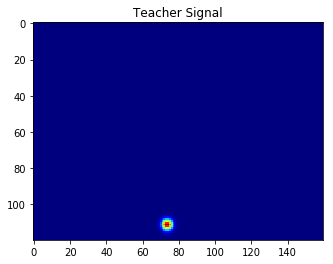

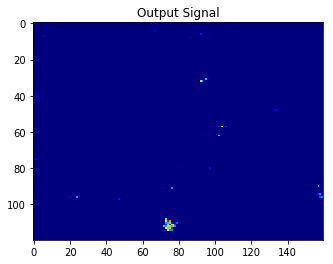

In [3]:
idx = 51
image = trainset[idx]['image']
signal = np.array(trainset[idx]['signal'].squeeze())

output = model(image.unsqueeze(0).float().to(device))
output_signal = np.array(output.cpu().squeeze().detach())

plt.title("RGB Image")
plt.imshow(np.array(image).transpose(1, 2, 0))
plt.show()

plt.title("Teacher Signal")
plt.imshow(signal, cmap=cm.jet)
plt.show()


plt.title("Output Signal")
plt.imshow(output_signal, cmap=cm.jet)
plt.show()

## Testing ConvLSTM

In [9]:
from conv_lstm import ConvLSTMCell

conv_lstm = ConvLSTMCell(1, 1, 1, device)

Size:  torch.Size([1, 1, 120, 160])
1 120 160
Hidden  torch.Size([1, 2, 120, 160])
conv_output  torch.Size([1, 4, 120, 160])
h_t - >  torch.Size([1, 1, 120, 160])
torch.Size([1, 1, 120, 160])


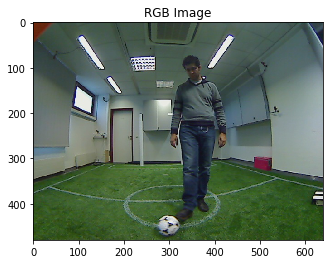

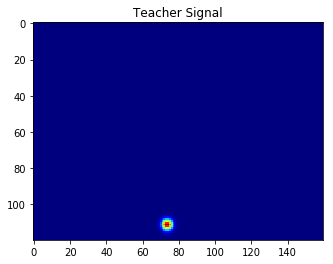

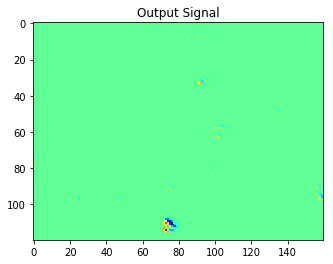

In [13]:
idx = 51
image = trainset[idx]['image']
signal = np.array(trainset[idx]['signal'].squeeze())

output = model(image.unsqueeze(0).float().to(device))

output, c_t = conv_lstm(output)

print(output.size())
output_signal = np.array(output.cpu().squeeze().detach())

plt.title("RGB Image")
plt.imshow(np.array(image).transpose(1, 2, 0))
plt.show()

plt.title("Teacher Signal")
plt.imshow(signal, cmap=cm.jet)
plt.show()


plt.title("Output Signal")
plt.imshow(output_signal, cmap=cm.jet)
plt.show()